# Exercício DNE II

## Identificando spams de hams - 26/08/2022

In [1]:
# Carrega as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [2]:
# Queremos identificar se a mensagem é um spam (1) ou não (0)
spam = pd.read_csv("dataset/SMSSpamCollection", sep = "\t", names = ["label","message"])
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
spam.info()
# Sem valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
# Trocando os labels para '0' ('ham') e '1' ('spam')
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label = le.fit_transform(spam["label"])

In [5]:
label

array([0, 0, 1, ..., 0, 0, 0])

In [6]:
spam["label"] = label
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Baixa as listas de stopwords e as tokenizações
nltk.download('stopwords')
nltk.download('punkt')

# Define as stopwords em inglês
sw_english = set(stopwords.words('english'))

# Instancia o PorterStemmer | trocar por lemmatização
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Função de Stemming
def pre_text(string):
    string = re.sub(r"[^a-zA-Z0-9]+", " ", string)
    string = string.lower()
    words = word_tokenize(string)
    filter_words = [word for word in words if word not in sw_english]
    stem_words = []
    for word in filter_words:
        sw = stemmer.stem(word)
        stem_words.append(sw)
    return stem_words

In [9]:
spam['filtered_words'] = spam["message"].apply(lambda x: pre_text(x))
spam['join_words'] = spam['filtered_words'].apply(lambda x: ' '.join(x))

In [10]:
from sklearn.model_selection import train_test_split


X = spam["join_words"]
y = spam["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

### TrucatedSVD

- Tem muitas features e queremos reduzir a quantidade
- Sabemos que temos features não relevants
- Antes de aplicar o PCA devemos escalar as features originais com StandardScaler
- https://analyticsindiamag.com/beginners-guide-to-truncated-svd-for-dimensionality-reduction/
- https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

### LogisticRegression

In [29]:
# Usar SVD ao invés de PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sc", StandardScaler(with_mean=False)),
    ("svd", TruncatedSVD(n_components = 10, random_state = 42)),
    ("lr", LogisticRegression())
])

text_lr

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sc', StandardScaler(with_mean=False)),
                ('svd', TruncatedSVD(n_components=10, random_state=42)),
                ('lr', LogisticRegression())])

In [30]:
text_lr.fit(X_train, y_train)
predictions = text_lr.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1209
           1       0.93      0.77      0.84       184

    accuracy                           0.96      1393
   macro avg       0.95      0.88      0.91      1393
weighted avg       0.96      0.96      0.96      1393

0.9612347451543432


In [32]:
y_prob_lr = text_lr.predict_proba(X_test)
# Slice do predict proba
y_prob_lr = y_prob_lr[:,1] 

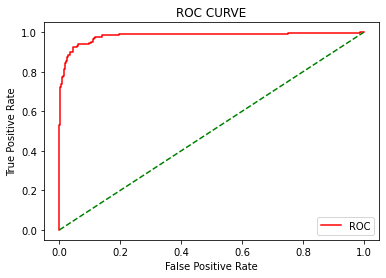

In [33]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_lr)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [34]:
auc = roc_auc_score(y_test, y_prob_lr)
print(auc)

0.9792273528248283


### Random Forest Classifier

In [41]:
# Usar SVD ao invés de PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_rf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sc", StandardScaler(with_mean=False)),
    ("svd", TruncatedSVD(n_components = 50, random_state = 42)),
    ("rf", RandomForestClassifier())
])

text_rf

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sc', StandardScaler(with_mean=False)),
                ('svd', TruncatedSVD(n_components=50, random_state=42)),
                ('rf', RandomForestClassifier())])

In [42]:
text_rf.fit(X_train, y_train)
predictions = text_rf.predict(X_test)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1209
           1       0.95      0.87      0.91       184

    accuracy                           0.98      1393
   macro avg       0.96      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393

0.9763101220387652


In [44]:
y_prob_rf = text_rf.predict_proba(X_test)
y_prob_rf = y_prob_rf[:,1]

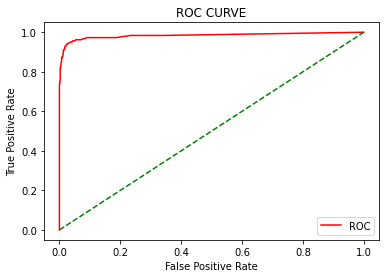

In [45]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_rf)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [46]:
auc = roc_auc_score(y_test, y_prob_rf)
print(auc)

0.9835607940446649


#### Dense transform : Para trabalhar com matrizes esparsas

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

class DenseTransformer():
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

# modelo 5: stem + log + pca
text_stem_log_pca = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('to_dense', DenseTransformer()),
    ('pca', PCA(n_components=0.8)),
    ('c', LogisticRegression())
])

In [12]:
text_stem_log_pca.fit(X_train, y_train)
predictions = text_stem_log_pca.predict(X_test)

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1194
           1       0.96      0.74      0.84       199

    accuracy                           0.96      1393
   macro avg       0.96      0.87      0.91      1393
weighted avg       0.96      0.96      0.96      1393

0.95908111988514


In [14]:
y_prob_pca_lr = text_stem_log_pca.predict_proba(X_test)
y_prob_pca_lr = y_prob_pca_lr[:,1]

C:\Users\gabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


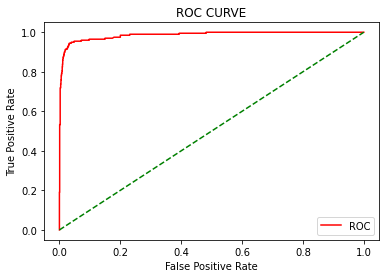

In [15]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_pca_lr)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [16]:
auc = roc_auc_score(y_test, y_prob_pca_lr)
print(auc)

0.9859641591542302


---

## Word Embedding - 2022-08-29

In [14]:
spam.head()

,label,message,filtered_words,join_words
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joke, wif, u, oni]",ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goe, usf, live, around, though]",nah think goe usf live around though


Utilizaremos a coluna ["filtered_words"]

In [11]:
# Word2Vec
from gensim.models import Word2Vec

In [66]:
# Define o modelo - utiliza-se dados como listas
model = Word2Vec(spam["filtered_words"], min_count = 2)

# Palavras do vocab
words = list(model.wv.index_to_key)

# 10 primeiras palavras
print(f"As quatro primeiras palavras são : {words[:10]}")

As quatro primeiras palavras são : ['u', 'call', '2', 'go', 'get', 'ur', '4', 'gt', 'lt', 'come']


In [51]:
words

['u',
 'call',
 '2',
 'go',
 'get',
 'ur',
 '4',
 'gt',
 'lt',
 'come',
 'ok',
 'free',
 'day',
 'know',
 'love',
 'like',
 'time',
 'got',
 'good',
 'want',
 'text',
 'send',
 'need',
 'txt',
 'one',
 'today',
 '1',
 'take',
 'see',
 'stop',
 'home',
 'think',
 'repli',
 'r',
 'lor',
 'sorri',
 'still',
 'tell',
 'n',
 'mobil',
 'back',
 'da',
 'dont',
 'make',
 'k',
 'pleas',
 'week',
 'phone',
 'say',
 'hi',
 'new',
 'work',
 'pl',
 'later',
 'hope',
 'miss',
 'ask',
 'co',
 'meet',
 'msg',
 'messag',
 'night',
 'dear',
 'c',
 'wait',
 'happi',
 'well',
 'give',
 'tri',
 'thing',
 'great',
 'much',
 'min',
 'oh',
 'claim',
 'wat',
 'hey',
 'number',
 'na',
 'friend',
 'thank',
 '3',
 'ye',
 'way',
 'www',
 'let',
 'e',
 'prize',
 'feel',
 'even',
 'right',
 'tomorrow',
 'wan',
 'pick',
 'alreadi',
 'said',
 'care',
 'cash',
 'b',
 'amp',
 'leav',
 'im',
 'yeah',
 'realli',
 'tone',
 'babe',
 'win',
 'life',
 'morn',
 'find',
 'sleep',
 'last',
 'keep',
 'uk',
 'servic',
 'sure',
 'b

In [64]:
# Palavras similares de 'prize'
model.wv.most_similar('prize')[:4]

[('claim', 0.9995793104171753),
 ('1000', 0.9995244741439819),
 ('cash', 0.9995195865631104),
 ('guarante', 0.9994425177574158)]

In [65]:
# Vetor da palavra 'prize'
print(model.wv.get_vector('prize', norm = True))

[-9.33288336e-02  1.22015327e-01  2.18123049e-02  1.95371118e-04
  1.66133717e-02 -1.64992169e-01  4.75053675e-02  2.82332987e-01
 -1.26484036e-01 -3.44158299e-02 -6.43697679e-02 -2.65016764e-01
 -4.62368913e-02  5.50912432e-02  4.03591655e-02 -9.59417894e-02
 -2.83580963e-02 -1.72965467e-01  9.56885517e-03 -2.30304450e-01
  5.39865382e-02  6.74208924e-02  6.53579831e-02 -2.20526885e-02
 -8.04831758e-02  1.00115659e-02 -7.33111128e-02 -6.39585182e-02
 -7.56089464e-02 -1.68418270e-02  1.07114010e-01  2.58764252e-02
  3.24872956e-02 -9.48043540e-02 -6.21581115e-02  1.18089736e-01
  3.43962051e-02 -1.24900162e-01 -8.53429884e-02 -2.19282478e-01
  2.61735357e-02 -1.14995435e-01 -5.03745675e-02  2.99331322e-02
  1.24768905e-01 -1.83290392e-02 -1.10457137e-01 -4.64935228e-03
  6.61905035e-02  7.80270547e-02  6.90250918e-02 -1.44729346e-01
 -3.99924330e-02  5.76978773e-02 -1.21314541e-01  6.39251918e-02
  7.37048835e-02 -6.15081005e-02 -1.24609508e-01  5.95778227e-02
  3.35640945e-02  6.32779